<a href="https://colab.research.google.com/github/Niloy-24/Transfer-Learning-Based-Classification-Of-Eye-Disease/blob/main/Mobilenet_NormalVsUvetis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
PATH = '/content/gdrive/MyDrive/Thesis/Data/NormalVsUvetis/'
train_dir = os.path.join(PATH, 'Train')
test_dir = os.path.join(PATH, 'Test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1469 files belonging to 2 classes.


In [4]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 386 files belonging to 2 classes.


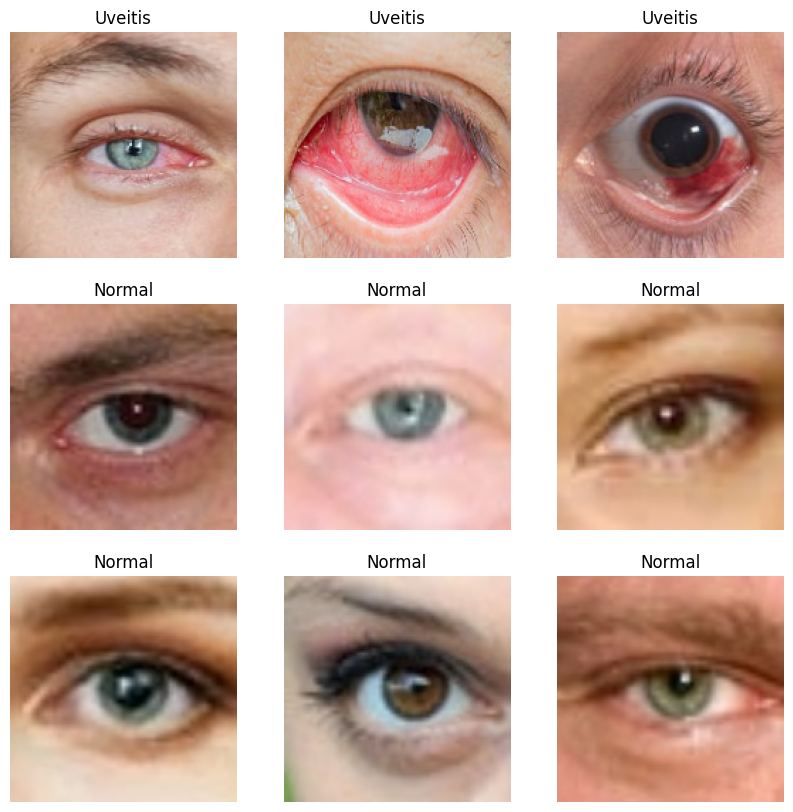

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
test_batches = tf.data.experimental.cardinality(test_dataset)
val_dataset = test_dataset.take(test_batches // 7)
val_dataset = test_dataset.skip(test_batches // 7)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 12
Number of test batches: 13


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

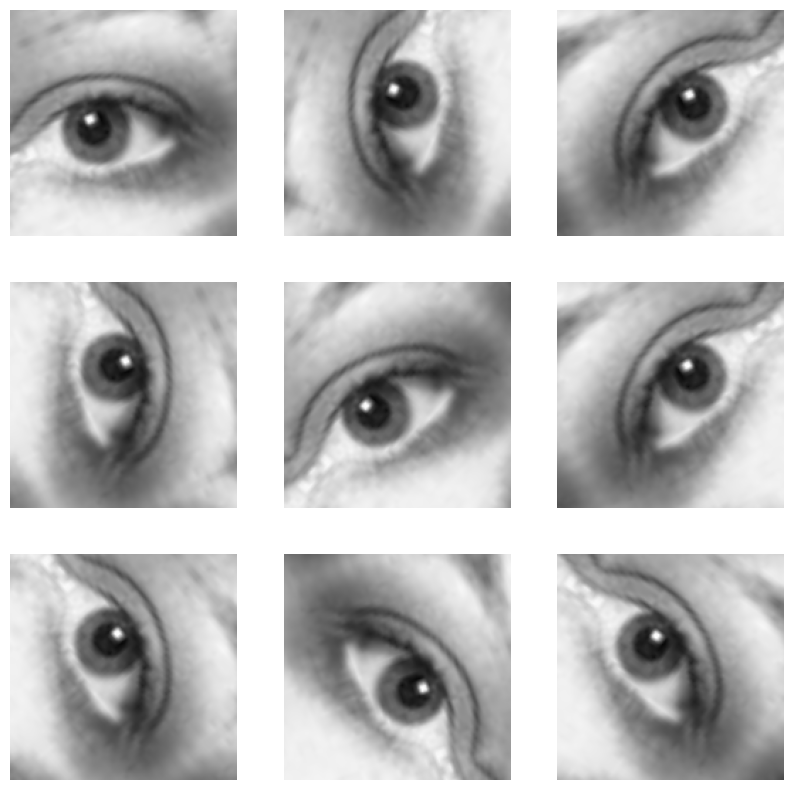

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_dataset)

12/12 [==============================] - 48s 723ms/step - loss: 5.0008 - accuracy: 0.5395


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.00
initial accuracy: 0.54


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/50
46/46 [==============================] - 90s 2s/step - loss: 4.7668 - accuracy: 0.5371 - val_loss: 4.2545 - val_accuracy: 0.5311
Epoch 2/50
46/46 [==============================] - 6s 122ms/step - loss: 4.6680 - accuracy: 0.5650 - val_loss: 4.2225 - val_accuracy: 0.5424
Epoch 3/50
46/46 [==============================] - 5s 95ms/step - loss: 4.1044 - accuracy: 0.5827 - val_loss: 3.7627 - val_accuracy: 0.5537
Epoch 4/50
46/46 [==============================] - 5s 94ms/step - loss: 3.7925 - accuracy: 0.6215 - val_loss: 3.1615 - val_accuracy: 0.6271
Epoch 5/50
46/46 [==============================] - 6s 123ms/step - loss: 3.5383 - accuracy: 0.6351 - val_loss: 3.3532 - val_accuracy: 0.6130
Epoch 6/50
46/46 [==============================] - 5s 99ms/step - loss: 3.8518 - accuracy: 0.6290 - val_loss: 3.1102 - val_accuracy: 0.6299
Epoch 7/50
46/46 [==============================] - 6s 112ms/step - loss: 3.0426 - accuracy: 0.6705 - val_loss: 2.9384 - val_accuracy: 0.6412
Epoch 8/50


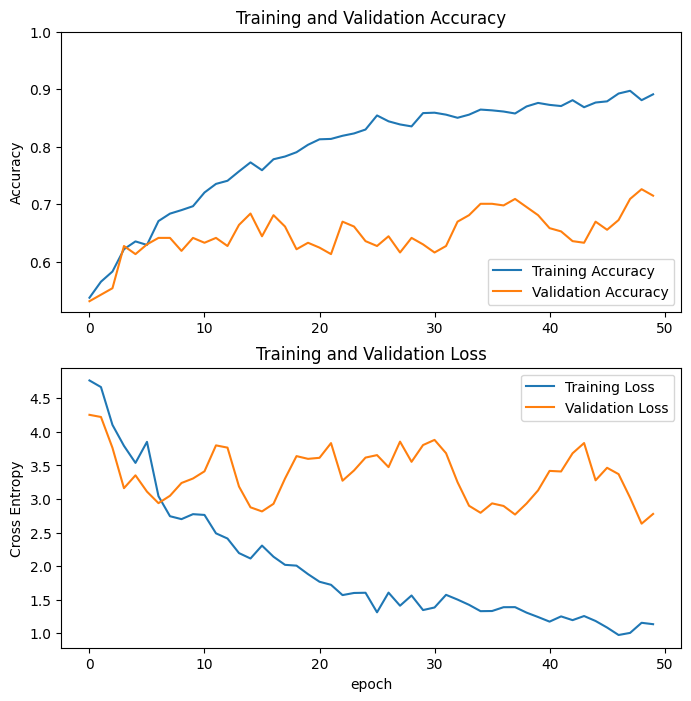

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[fine_tune_at:]:
  layer.trainable = True

Number of layers in the base model:  8


In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [29]:
len(model.trainable_variables)

158

In [30]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 50/100
46/46 [==============================] - 35s 183ms/step - loss: 0.8627 - accuracy: 0.9108 - val_loss: 1.5745 - val_accuracy: 0.8136
Epoch 51/100
46/46 [==============================] - 6s 119ms/step - loss: 0.7591 - accuracy: 0.9190 - val_loss: 2.3053 - val_accuracy: 0.8079
Epoch 52/100
46/46 [==============================] - 7s 152ms/step - loss: 0.5599 - accuracy: 0.9394 - val_loss: 1.5313 - val_accuracy: 0.8418
Epoch 53/100
46/46 [==============================] - 6s 119ms/step - loss: 0.4406 - accuracy: 0.9537 - val_loss: 2.0621 - val_accuracy: 0.7994
Epoch 54/100
46/46 [==============================] - 6s 121ms/step - loss: 0.4275 - accuracy: 0.9592 - val_loss: 2.1009 - val_accuracy: 0.8220
Epoch 55/100
46/46 [==============================] - 7s 143ms/step - loss: 0.3631 - accuracy: 0.9639 - val_loss: 1.6796 - val_accuracy: 0.8475
Epoch 56/100
46/46 [==============================] - 6s 117ms/step - loss: 0.3964 - accuracy: 0.9653 - val_loss: 0.9112 - val_accuracy

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

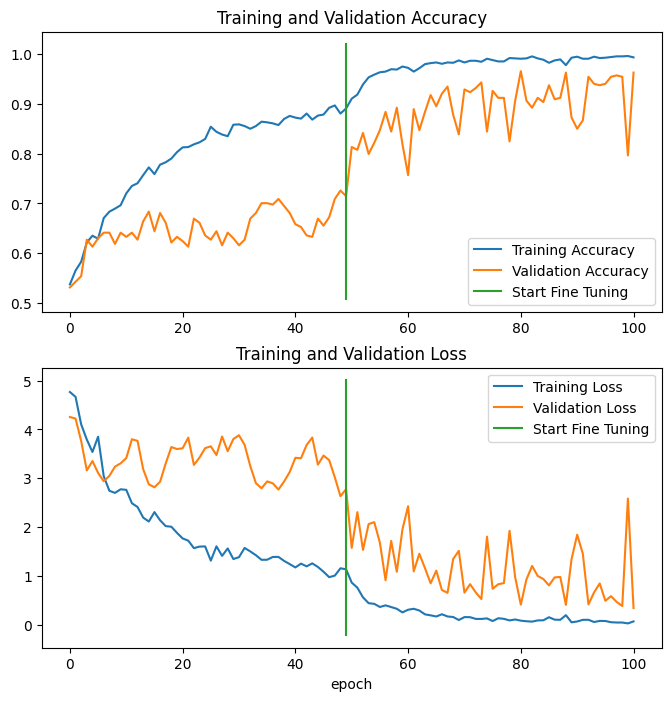

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

13/13 [==============================] - 1s 45ms/step - loss: 0.3198 - accuracy: 0.9611
Test accuracy : 0.9611399173736572


Predictions:
 [0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1]
Labels:
 [0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1]


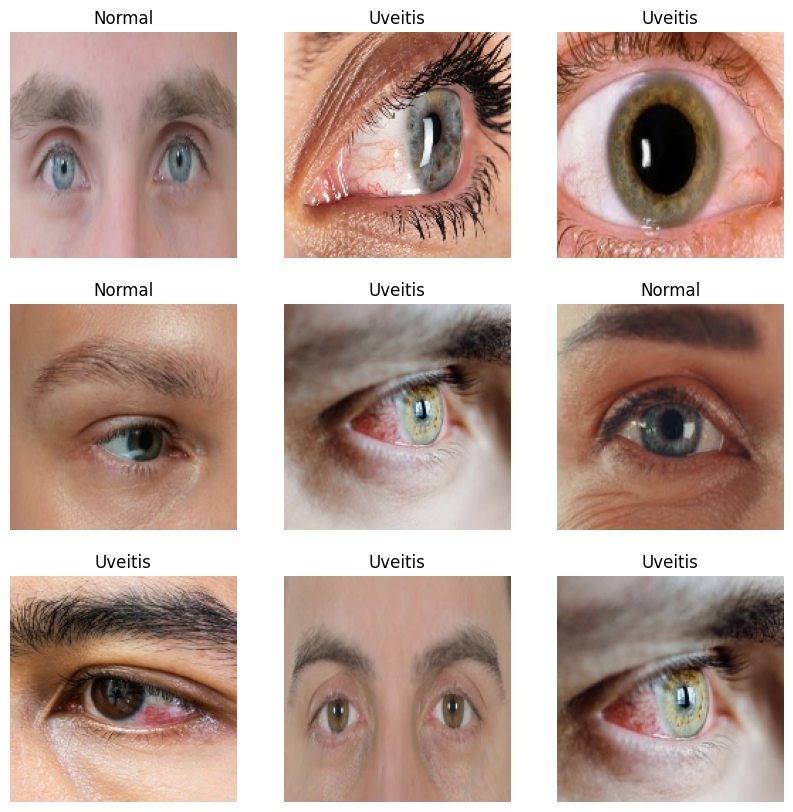

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [35]:
len(list(test_dataset))

13

In [36]:
# True labels
true_labels = []
for batch in test_dataset:
    labels = batch[1]  # Assuming labels are the second component of each batch
    true_labels.extend(labels.numpy().tolist())

# Predicted labels
predicted_labels = model.predict(test_dataset)
predicted_labels = tf.nn.sigmoid(predicted_labels)
predicted_labels = tf.where(predicted_labels < 0.5, 0, 1)

# Calculate true positives, true negatives, false positives, and false negatives
true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 1), tf.equal(predicted_labels, 1)), tf.float32))
true_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 0), tf.equal(predicted_labels, 0)), tf.float32))
false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 0), tf.equal(predicted_labels, 1)), tf.float32))
false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 1), tf.equal(predicted_labels, 0)), tf.float32))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels, predicted_labels), tf.float32))

# Calculate True Positive Rate (TPR) or Recall
tpr = true_positives / (true_positives + false_negatives)

# Calculate True Negative Rate (TNR)
tnr = true_negatives / (true_negatives + false_positives)

# Calculate False Positive Rate (FPR)
fpr = false_positives / (false_positives + true_negatives)

# Calculate False Negative Rate (FNR)
fnr = false_negatives / (false_negatives + true_positives)

# Calculate Precision
precision = true_positives / (true_positives + false_positives)

# Calculate F1 Score
f1_score = 2 * ((precision * tpr) / (precision + tpr))

# Print the performance metrics

print("True Positive Rate (TPR) or Recall:", tpr.numpy())
print("True Negative Rate (TNR):", tnr.numpy())
print("False Positive Rate (FPR):", fpr.numpy())
print("False Negative Rate (FNR):", fnr.numpy())
print("Precision:", precision.numpy())
print("F1 Score:", f1_score.numpy())

13/13 [==============================] - 2s 62ms/step
True Positive Rate (TPR) or Recall: 0.5051814
True Negative Rate (TNR): 0.49481866
False Positive Rate (FPR): 0.5051814
False Negative Rate (FNR): 0.49481866
Precision: 0.4818653
F1 Score: 0.49324793


In [37]:
predicted_labels

<tf.Tensor: shape=(386, 1), dtype=int32, numpy=
array([[1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
    

In [38]:
true_labels

[0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,


In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate true positive rate (TPR) or recall
tpr = tp / (tp + fn)
print("True Positive Rate (TPR):", tpr)

# Calculate true negative rate (TNR)
tnr = tn / (tn + fp)
print("True Negative Rate (TNR):", tnr)

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn)
print("False Positive Rate (FPR):", fpr)

# Calculate false negative rate (FNR)
fnr = fn / (fn + tp)
print("False Negative Rate (FNR):", fnr)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print("Precision:", precision)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)


True Positive Rate (TPR): 0.5
True Negative Rate (TNR): 0.49
False Positive Rate (FPR): 0.51
False Negative Rate (FNR): 0.5
Precision: 0.47692307692307695
F1 Score: 0.4881889763779527


In [40]:
from tensorflow.keras.models import load_model

model.save('/content/gdrive/MyDrive/Saved_Model/Mobilenet_NormalVsUvetis.h5')